In [3]:
import os
from dotenv import load_dotenv

#dotenv_path = os.path.join(os.path.dirname(__file__), '..', '..', '.env')
load_dotenv()

import matplotlib.pyplot as plt
from gluonts.dataset.repository import dataset_recipes

from uni2ts.eval_util.data import get_gluonts_test_dataset
from uni2ts.eval_util.plot import plot_next_multi
from uni2ts.model.moirai import MoiraiForecast, MoiraiModule
from uni2ts.model.moirai_moe import MoiraiMoEForecast, MoiraiMoEModule


In [4]:
## settings
MODEL = "moirai-moe"  # model name: choose from {'moirai', 'moirai-moe'}
SIZE = "small"  # model size: choose from {'small', 'base', 'large'}
CTX = 1000  # context length: any positive integer
PSZ = "auto"  # patch size: choose from {"auto", 8, 16, 32, 64, 128}
BSZ = 32  # batch size: any positive integer

In [5]:
# Load dataset using loader utils
test_data, metadata = get_gluonts_test_dataset(
    "bitcoin", prediction_length=None, regenerate=False
)
print(metadata)

## result
# MetaData(freq='D', target_dim=1, prediction_length=30, feat_dynamic_real_dim=0, past_feat_dynamic_real_dim=0, split='test')



MetaData(freq='D', target_dim=1, prediction_length=30, feat_dynamic_real_dim=0, past_feat_dynamic_real_dim=0, split='test')


In [6]:
# Prepare model
if MODEL == "moirai":
    model = MoiraiForecast(
        module=MoiraiModule.from_pretrained(
            f"Salesforce/moirai-1.1-R-{SIZE}",
        ),
        prediction_length=metadata.prediction_length,
        context_length=CTX,
        patch_size=PSZ,
        num_samples=100,
        target_dim=metadata.target_dim,
        feat_dynamic_real_dim=metadata.feat_dynamic_real_dim,
        past_feat_dynamic_real_dim=metadata.past_feat_dynamic_real_dim,
    )
elif MODEL == "moirai-moe":
    model = MoiraiMoEForecast(
        module=MoiraiMoEModule.from_pretrained(
            f"Salesforce/moirai-moe-1.0-R-{SIZE}",
        ),
        prediction_length=metadata.prediction_length,
        context_length=CTX,
        patch_size=16,
        num_samples=100,
        target_dim=metadata.target_dim,
        feat_dynamic_real_dim=metadata.feat_dynamic_real_dim,
        past_feat_dynamic_real_dim=metadata.past_feat_dynamic_real_dim,
    )

In [7]:
predictor = model.create_predictor(batch_size=BSZ)
forecasts = predictor.predict(test_data.input)

input_it = iter(test_data.input)
label_it = iter(test_data.label)
forecast_it = iter(forecasts)

In [8]:
## Make predictions
inp = next(input_it)  # input / lookback window
label = next(label_it)  # label / forecast horizon
forecast = next(forecast_it)  # predictions (GluonTS Forecast object)

print(inp.keys(), label.keys())
print(inp["target"].shape, label["target"].shape)
print(forecast.samples.shape)

dict_keys(['target', 'start', 'item_id', 'feat_static_cat']) dict_keys(['target', 'start', 'item_id', 'feat_static_cat'])
(4551,) (30,)
(100, 30)


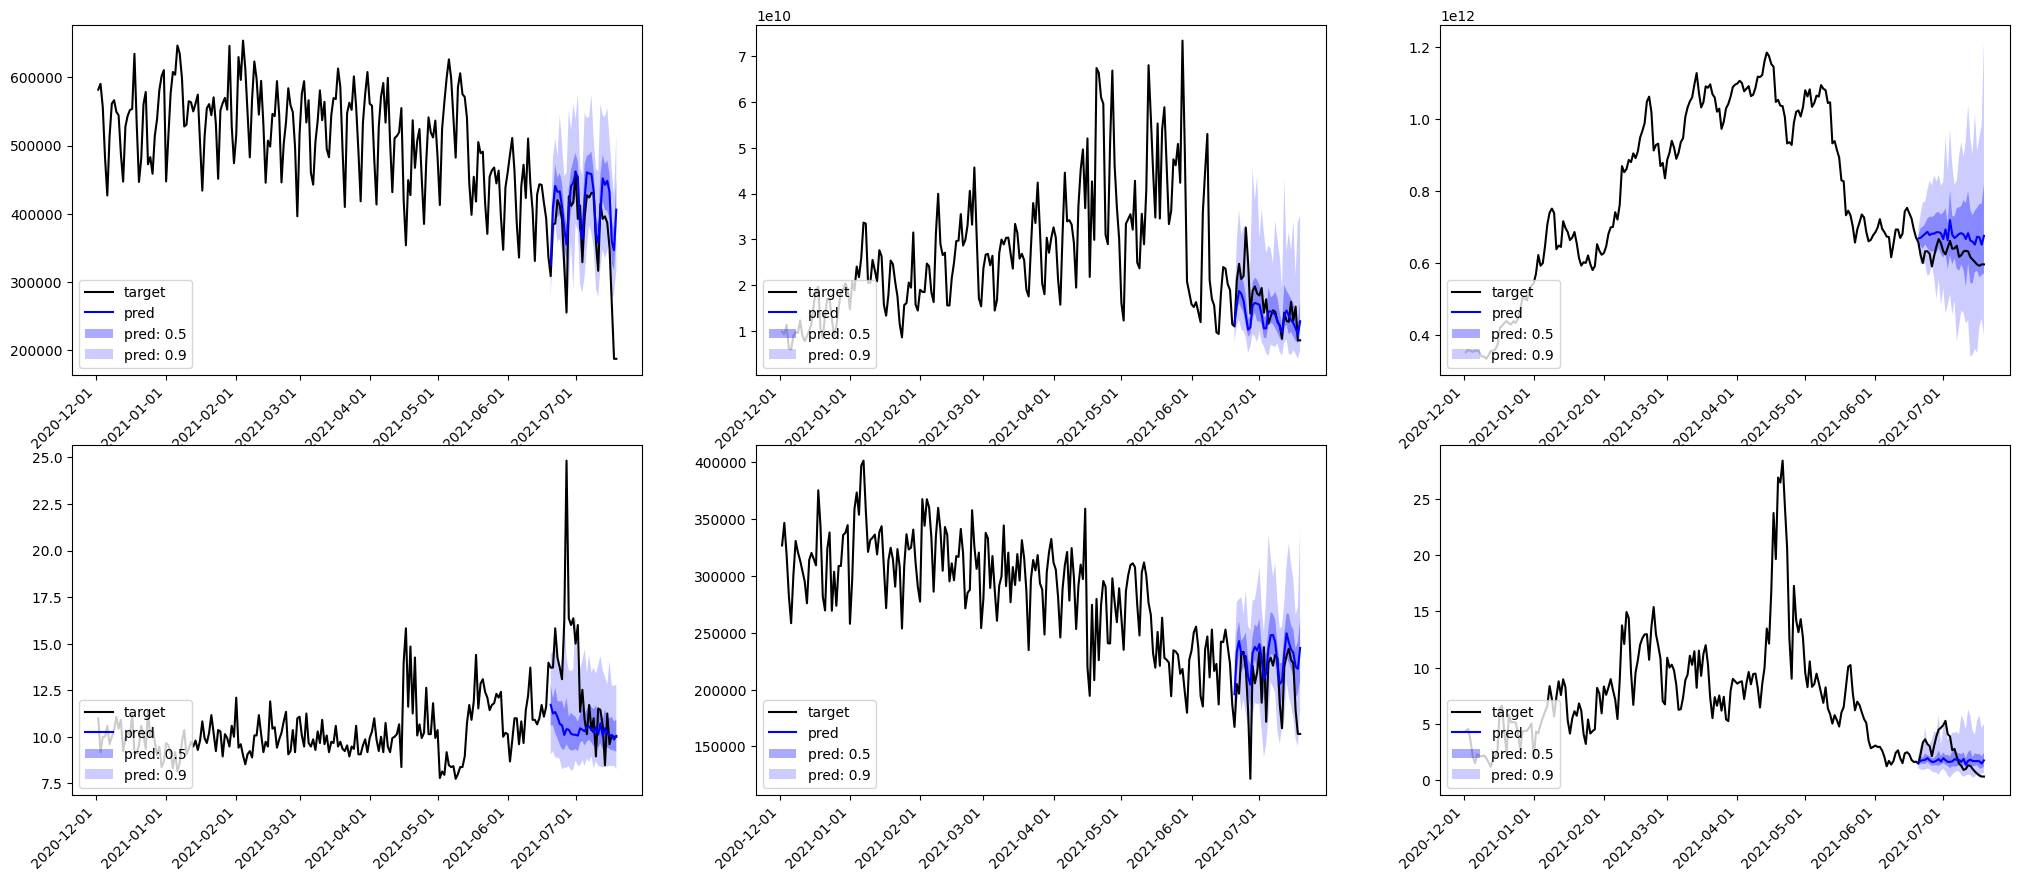

In [9]:
# Visualize forecasts
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(25, 10))
plot_next_multi(
    axes,
    input_it,
    label_it,
    forecast_it,
    context_length=200,
    intervals=(0.5, 0.9),
    dim=None,
    name="pred",
    show_label=True,
)